Dans ce portefeuille, nous allons appliquer la logique de procédure suivante : 
1) Téléchargement des prix
2) Calcul des rendements / espérances $\mu$
3) Calcul des variances / volatilités $\sigma$
4) Calcul des coefficients de corrélations
5) Constitution du potefeuille (choix des poids)
6) Détermination de la frontière efficiente
7) Modèle CAPM + droite SML
8) Interprétation financière en contexte

On étudie 4 actifs, couplés deux à deux en long/short : 
- Secteur IA/Semi-condu : ASML et AMD
- Secteur Luxe : Richemont et HUGO BOSS

In [170]:
""" Bibliothèques à importer pour tout le portefeuille """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import yfinance as yf             # permet d'utiliser toutes les bases de données de YahooFinance
from scipy import stats
from scipy.optimize import minimize
from IPython.display import display, Math

plt.rcParams["figure.figsize"] = (8,5)   # Dimensions de figure génériques pour tous les graphiques

In [171]:
# Tickers des entreprises cotés dont on récupère les cours de bourse
tickers = ["ASML", "AMD", "CFR.SW", "BOSS.DE"]
data = yf.download(
    tickers,
    start="2019-01-01",
    end="2026-01-31",   # pour inclure le 30 janvier 2026
    auto_adjust=True
)["Close"]

# On renomme les tickers avec les marques associées, pour plus de lisibilité
rename_map = {"BOSS.DE": "Hugo Boss","CFR.SW": "Richemont"}
data = data.rename(columns=rename_map)

# Petit affichage de la tête et la queue des données, pour vérifier qu'on a bien toute la plage de dates
print("Aperçu des données :")
print(data.head())
print("\nDernières dates :")
print(data.tail())

[*********************100%***********************]  4 of 4 completed

Aperçu des données :
Ticker            AMD        ASML  Hugo Boss  Richemont
Date                                                   
2019-01-02  18.830000  145.733459  47.467316        NaN
2019-01-03  17.049999  137.696228  46.738384  51.787632
2019-01-04  19.000000  143.654236  47.901207  53.731995
2019-01-07  20.570000  146.936234  47.745003  54.070145
2019-01-08  20.750000  145.854660  50.365685  55.000057

Dernières dates :
Ticker             AMD         ASML  Hugo Boss   Richemont
Date                                                      
2026-01-26  251.309998  1413.349976  34.700001  152.649994
2026-01-27  252.029999  1454.589966  34.580002  152.850006
2026-01-28  252.740005  1422.920044  34.490002  149.350006
2026-01-29  252.179993  1455.160034  34.619999  147.800003
2026-01-30  236.729996  1423.000000  35.000000  149.550003


In [172]:
# Calcul des taux d'évolution de rendement JOURNALIERS
returns = data.pct_change(fill_method=None).dropna()

""" 
La méthode .dropna() enlève automatiquement les lignes où il manque une donnée (jour férié, jour sans donnée etc..
Ici, on a supprimé 140 lignes sur les 1760 du total, ce qui reste relativement correct : on préfère perdre quelques données plutôt que
de voir la régression planter ou bien de devoir ajouter arbitrairement des données d'un jour à l'autre.
"""

returns = returns.rename(columns=rename_map)
print("Aperçu des rendements :")
print(returns.head())

print("\nStatistiques rapides :")
print(returns.describe())

Aperçu des rendements :
Ticker           AMD      ASML  Hugo Boss  Richemont
Date                                                
2019-01-04  0.114370  0.043269   0.024879   0.037545
2019-01-07  0.082632  0.022847  -0.003261   0.006293
2019-01-08  0.008751 -0.007361   0.054889   0.017198
2019-01-09 -0.026988  0.041488   0.015507   0.013219
2019-01-10 -0.022288 -0.001903   0.000339  -0.001820

Statistiques rapides :
Ticker          AMD         ASML    Hugo Boss    Richemont
count   1639.000000  1639.000000  1639.000000  1639.000000
mean       0.002003     0.001738     0.000234     0.000879
std        0.034189     0.026110     0.022294     0.020985
min       -0.146390    -0.173492    -0.149711    -0.135005
25%       -0.016697    -0.012177    -0.010254    -0.010068
50%        0.000389     0.002033     0.000000     0.000537
75%        0.019534     0.016366     0.010598     0.011546
max        0.238205     0.154341     0.157769     0.163610


In [173]:
mu = returns.mean() * 252
sigma = returns.std() * np.sqrt(252)
corr = returns.corr()
cov = returns.cov() * 252

mu.index.name = None
sigma.index.name = None
corr.index.name = corr.columns.name = None
cov.index.name = cov.columns.name = None

print("===== RENDEMENTS ANNUALISÉS =====")
print(mu.round(3).to_string())

print("\n===== VOLATILITÉS ANNUALISÉES =====")
print(sigma.round(3).to_string())

print("\n===== MATRICE DE COVARIANCE =====")
print(cov.round(3).to_string())

print("\n===== MATRICE DE CORRÉLATION =====")
print(corr.round(3).to_string())

print("\nCorrélations fortes (|ρ| > 0.45) :")

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        val = corr.iloc[i, j]
        if abs(val) > 0.45:
            print(f"{corr.columns[i]} / {corr.columns[j]} : {val:.3f}")

===== RENDEMENTS ANNUALISÉS =====
AMD          0.505
ASML         0.438
Hugo Boss    0.059
Richemont    0.222

===== VOLATILITÉS ANNUALISÉES =====
AMD          0.543
ASML         0.414
Hugo Boss    0.354
Richemont    0.333

===== MATRICE DE COVARIANCE =====
             AMD   ASML  Hugo Boss  Richemont
AMD        0.295  0.139      0.024      0.044
ASML       0.139  0.172      0.032      0.051
Hugo Boss  0.024  0.032      0.125      0.057
Richemont  0.044  0.051      0.057      0.111

===== MATRICE DE CORRÉLATION =====
             AMD   ASML  Hugo Boss  Richemont
AMD        1.000  0.618      0.124      0.241
ASML       0.618  1.000      0.219      0.368
Hugo Boss  0.124  0.219      1.000      0.482
Richemont  0.241  0.368      0.482      1.000

Corrélations fortes (|ρ| > 0.45) :
AMD / ASML : 0.618
Hugo Boss / Richemont : 0.482


Fortes corrélations intra-sectorielles : favorables aux stratégies long/short

Faibles corrélations inter-sectorielles : réduction du risque global (diversification)

In [175]:
weights = pd.Series({
    "ASML": 0.25,
    "AMD": -0.25,
    "Richemont": 0.25,
    "Hugo Boss": -0.25
})

portfolio_return = np.dot(weights, mu)
portfolio_risk = np.sqrt(weights.T @ cov @ weights)

print("===== PORTEFEUILLE LONG/SHORT =====")
print(weights.to_string())

print("\nRendement annuel attendu :", round(portfolio_return * 100, 2), "%")
print("Risque (volatilité) :", round(portfolio_risk * 100, 2), "%")

===== PORTEFEUILLE LONG/SHORT =====
ASML         0.25
AMD         -0.25
Richemont    0.25
Hugo Boss   -0.25

Rendement annuel attendu : -2.39 %
Risque (volatilité) : 13.9 %


In [227]:
""" Générations de portefeuilles aléatoires """
n_portfolios = 1000
results = []
weights_list = []
assets = mu.index.tolist()
n = len(assets)

for k in range(n_portfolios):
    w = np.random.uniform(-1, 1, n)
    w = w / np.sum(np.abs(w))   # normalisation long/short
    ret = np.dot(w, mu)
    risk = np.sqrt(w.T @ cov @ w)
    results.append([risk, ret])
    weights_list.append(w)
results = np.array(results)

On optimise le portefeuille, via le critère du sharpe (ratio rendement/risque) :

In [178]:
# Optimisation avec le Sharpe Ratio
sharpe_ratios = results[:,1] / results[:,0]
best_idx = np.argmax(sharpe_ratios)
best_risk = results[best_idx,0]
best_return = results[best_idx,1]
best_weights = weights_list[best_idx]
optimal_portfolio = pd.Series(best_weights, index=assets)
best_sharpe = best_return / best_risk

print("===== PORTEFEUILLE OPTIMAL =====")
print(optimal_portfolio.round(3).to_string())

print("\nRendement :", round(best_return*100,2),"%")
print("Risque :", round(best_risk*100,2),"%")
print("Sharpe ratio :", round(best_sharpe,3))

===== PORTEFEUILLE OPTIMAL =====
AMD          0.227
ASML         0.409
Hugo Boss   -0.135
Richemont    0.229

Rendement : 33.65 %
Risque : 28.88 %
Sharpe ratio : 1.165


Hmmmmm petit soucis, mon portefeuille optimal serait finalement constitué d'un seul short et de 3 long, pour avoir 
une position préférentielle. Cherchons juste après, une nouvelle optimisation, en gardant la contrainte initiale de deux couples L/S.

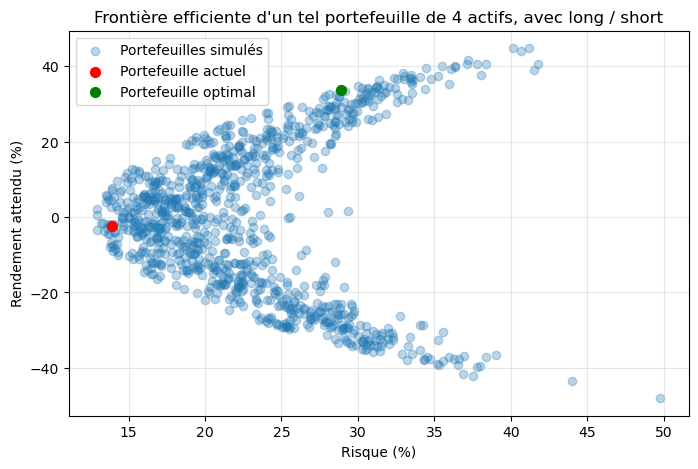

In [180]:
size_point = 50
plt.scatter(results[:,0]*100, results[:,1]*100, alpha=0.3, label="Portefeuilles simulés")
plt.scatter(portfolio_risk * 100, portfolio_return * 100, color="red", s=50, label="Portefeuille actuel")
plt.scatter(best_risk*100, best_return*100, color="green", s=size_point, label="Portefeuille optimal")
plt.xlabel("Risque (%)")
plt.ylabel("Rendement attendu (%)")
plt.title("Frontière efficiente d'un tel portefeuille de 4 actifs, avec long / short")
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [181]:
def portfolio_stats_Markowitz(w):
    ret = np.dot(w, mu)
    risk = np.sqrt(w.T @ cov @ w)
    return ret, risk

def neg_sharpe(w):
    ret, risk = portfolio_stats_Markowitz(w)
    return -ret / risk

def f_contrainte(w):
    return (np.sum(np.abs(w)) - 1)

""" Préparation pour optimisation : """
constraints = [{"type": "eq", "fun": f_contrainte}]
# Alternative : constraints = [{"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1}]

lim_short = (-1, -0.001)
lim_long = (0.001, 1)
bounds = [lim_short,lim_long]*2       # à changer selon le nombre d'actifs dans le portfolio
w0 = np.array([0.25, -0.25, 0.25, -0.25])
opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=constraints)
w_opt = opt.x
ret_opt, risk_opt = portfolio_stats_Markowitz(w_opt)
sharpe_opt = ret_opt / risk_opt
portfolio_constrained = pd.Series(w_opt, index=assets)

print("===== PORTEFEUILLE OPTIMAL CONTRAINT =====")
print(portfolio_constrained.round(3).to_string())

print("\nRendement (%) :", round(ret_opt*100,2))
print("Risque (%) :", round(risk_opt*100,2))
print("Sharpe :", round(sharpe_opt,3))

===== PORTEFEUILLE OPTIMAL CONTRAINT =====
AMD         -0.001
ASML         0.532
Hugo Boss   -0.164
Richemont    0.303

Rendement (%) : 28.99
Risque (%) : 25.92
Sharpe : 1.119


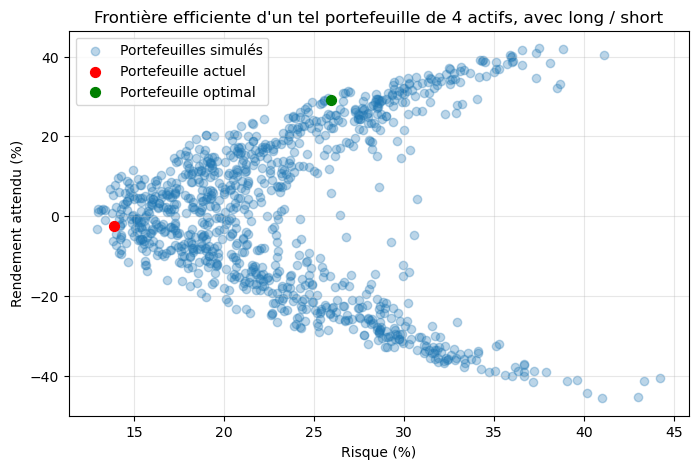

In [229]:
size_point = 50
plt.scatter(results[:,0]*100, results[:,1]*100, alpha=0.3, label="Portefeuilles simulés")
plt.scatter(portfolio_risk * 100, portfolio_return * 100, color="red", s=50, label="Portefeuille actuel")
plt.scatter(risk_opt*100, ret_opt*100, color="green", s=size_point, label="Portefeuille optimal")
plt.xlabel("Risque (%)")
plt.ylabel("Rendement attendu (%)")
plt.title("Frontière efficiente d'un tel portefeuille de 4 actifs, avec long / short")
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [182]:
capital = 12_500
allocations = portfolio_constrained * capital
print("===== ALLOCATION (montant en €) =====")
print(allocations.round(2).to_string())

print("\nTotal engagé :", round(np.sum(np.abs(allocations)), 2), "€")

===== ALLOCATION (montant en €) =====
AMD           -12.50
ASML         6652.22
Hugo Boss   -2050.38
Richemont    3784.90

Total engagé : 12500.0 €


In [183]:
# Expression des résultats en nombre d'actions aux prix fixés du 30/01/2026
last_prices = data.loc[data.index.max()]
shares = (allocations / last_prices).apply(np.floor)  # arrondi vers le bas

print("===== PRIX DE L'ACTION AU 30/01/2026 (en €) =====")
print(last_prices.round(2).to_string())

print("\n===== ALLOCATIONS (en €) =====")
print(allocations.round(2).to_string())

print("\n===== NOMBRE D’ACTIONS DANS LE PORTEFEUILLE =====")
print(shares.to_string())

# calcul du coût réel
real_cost = (shares * last_prices).abs().sum()
print(f"\nCoût total : {real_cost.round(2)} €")

===== PRIX DE L'ACTION AU 30/01/2026 (en €) =====
Ticker
AMD           236.73
ASML         1423.00
Hugo Boss      35.00
Richemont     149.55

===== ALLOCATIONS (en €) =====
AMD           -12.50
ASML         6652.22
Hugo Boss   -2050.38
Richemont    3784.90

===== NOMBRE D’ACTIONS DANS LE PORTEFEUILLE =====
AMD          -1.0
ASML          4.0
Hugo Boss   -59.0
Richemont    25.0

Coût total : 11732.48 €


Il nous reste une partie conséquente du capital, on peut donc essayer d'optimiser encore un peu plus en allouant
plus de capital.

In [185]:
scale = capital / real_cost
scaled_allocations = allocations * scale
scaled_shares = (scaled_allocations / last_prices).apply(np.floor)
real_cost_scaled = (scaled_shares * last_prices).abs().sum()

print("===== ACTIONS AJUSTÉES (pour maximiser l'utilisation du capital) =====")
print(scaled_shares.to_string())

print("\nCapital utilisé :", round(real_cost_scaled,2), "€")
print("Capital restant :", round(capital - real_cost_scaled,2), "€")

===== ACTIONS AJUSTÉES (pour maximiser l'utilisation du capital) =====
AMD          -1.0
ASML          4.0
Hugo Boss   -63.0
Richemont    26.0

Capital utilisé : 12022.03 €
Capital restant : 477.97 €


Maintenant, on passe à la méthode CAPM, il faut donc télécharger des données relatives au marché.

In [187]:
market = yf.download(
    "^GSPC",
    start="2019-01-01",
    end="2026-01-31",
    auto_adjust=True     # permet de s'affranchir des dividendes et des splits corrigés
)["Close"]

market_returns = market.pct_change(fill_method=None).dropna()
market_returns.name = "Market"

[*********************100%***********************]  1 of 1 completed


In [188]:
capm_data = pd.concat([returns, market_returns], axis=1).dropna()
capm_data = capm_data.rename(columns={"^GSPC": "Market"})
#print(capm_data.head())
#print(capm_data.tail())

On fait la régression CAPM pour obtenir les valeurs des coefficients pour chaque actif

In [190]:
betas = {}
alphas_daily = {}
r2s = {}

for asset in returns.columns:
    y = capm_data[asset]
    x = capm_data["Market"]
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    betas[asset] = slope
    alphas_daily[asset] = intercept
    r2s[asset] = r**2

beta_series = pd.Series(betas)
alpha_daily_series = pd.Series(alphas_daily)
alpha_annual_series = alpha_daily_series * 252
r2_series = pd.Series(r2s)

print("===== BÊTAS =====")
print(beta_series.round(3).to_string())

print("\n===== ALPHAS journaliers =====")
print((alpha_daily_series).round(5).to_string())

print("\n===== ALPHAS ANNUALISÉS (%) =====")
print((alpha_annual_series * 100).round(2).to_string())

print("\n===== R² =====")
print(r2_series.round(3).to_string())

===== BÊTAS =====
AMD          1.700
ASML         1.431
Hugo Boss    0.511
Richemont    0.632

===== ALPHAS journaliers =====
AMD          0.00075
ASML         0.00068
Hugo Boss   -0.00014
Richemont    0.00041

===== ALPHAS ANNUALISÉS (%) =====
AMD          18.83
ASML         17.16
Hugo Boss    -3.61
Richemont    10.39

===== R² =====
AMD          0.396
ASML         0.482
Hugo Boss    0.084
Richemont    0.145


Bien que $\alpha(AMD)>0$, sa sensibilité élevée au marché $\beta(AMD) = 1.7 >1$ justifie une position short dans une logique de couverture du risque systématique et de structuration long/short du portefeuille, qui contraint deux couples.

In [192]:
portfolio_returns = returns @ portfolio_constrained
capm_portfolio = pd.concat([portfolio_returns, market_returns], axis=1).dropna()

capm_portfolio.columns = ["Portfolio", "Market"]
beta_p, alpha_p, r, p, err = stats.linregress(capm_portfolio["Market"],capm_portfolio["Portfolio"])

print("===== CAPM PORTEFEUILLE (journaliers) =====")
#print("Beta :", round(beta_p,3))
#print("Alpha :", round(alpha_p,5))
display(Math(r"\alpha = " + str(round(alpha_p,5))))
display(Math(r"\beta = " + str(round(beta_p,3))))
display(Math(r"\alpha_{\text{annuel}} = " + str(round(alpha_p * 252 * 100, 3)) + r"\%"))

===== CAPM PORTEFEUILLE (journaliers) =====


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Le portefeuille est donc stabilisateur et défensif ($\beta < 1$), mais avec un sharpe élevé, donc le risque est
maîtrisé.
Le coefficient $\alpha > 0$ suggère une capacité de surperformance, indépendante du marché, issue principalement de la sélection d’actifs et de la diversification sectorielle.

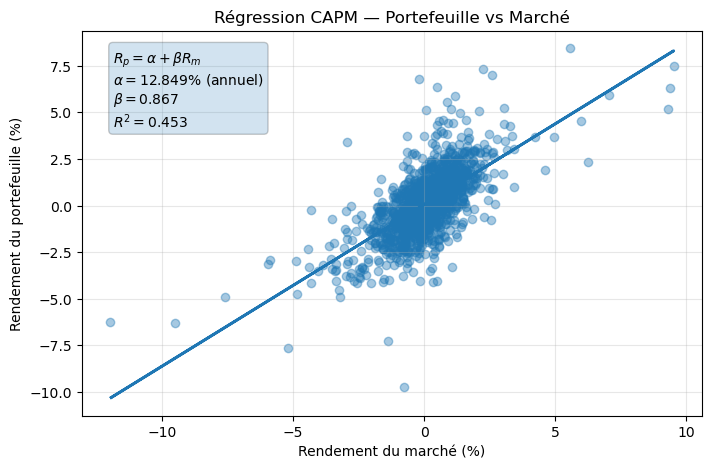

In [194]:
x = capm_portfolio["Market"]
y = capm_portfolio["Portfolio"]

beta_p, alpha_p, r, p, err = stats.linregress(x, y)
plt.scatter(x*100, y*100, alpha=0.4)
plt.plot(x*100, (alpha_p + beta_p*x)*100,linewidth=2)

eq_text = (
    r"$R_p = \alpha + \beta R_m$" "\n"
    rf"$\alpha = {round(alpha_p*252*100,3)}\%$ (annuel)" "\n"
    rf"$\beta = {round(beta_p,3)}$" "\n"
    rf"$R^2 = {round(r**2,3)}$"
)

plt.text(
    0.05, 0.95,
    eq_text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.xlabel("Rendement du marché (%)")
plt.ylabel("Rendement du portefeuille (%)")
plt.title("Régression CAPM — Portefeuille vs Marché")
plt.grid(True,alpha=0.3)
plt.show()

Le coefficient $R^2$ correspond à la part de la variance du portefeuille expliquée par le marché. Ainsi, dans notre
cas, le marché explique $45.3\%$ de la variance du portefeuille, et le reste provient de facteurs externes (entreprises, secteurs etc.)

Autrement dit, notre portfeuille n'est pas une "copie" du marché : il en capte une partie, mais reste bien diversifié.

In [196]:
Rf = yf.download(
    "^IRX",
    start="2019-01-01",
    end="2026-01-31",
    auto_adjust=True
)["Close"]

Rf = Rf/100 # on passe de % à décimal
Rf_daily = Rf/252
Rf_mean_daily = Rf_daily.mean().iloc[0]

[*********************100%***********************]  1 of 1 completed


L'idée est donc de récupérer les données sur le marché, puis d'utiliser le modèle de régression CAPM :

$$ R_{i,t} - R_{f,t} = \alpha_i + \beta_i \bigl(R_{m,t} - R_{f,t}\bigr) + \varepsilon_{i,t} $$

où les termes sont :

$$ \begin{aligned}
R_{i,t} & : \text{rendement de l’actif (ou du portefeuille) au temps } t \\
R_{m,t} & : \text{rendement du marché au temps } t \\
R_{f,t} & : \text{taux sans risque au temps } t \text{ récupéré dans la cellule précédente} \\
\alpha_i & : \text{performance anormale (sur ou sous) non expliquée par le marché} \\
\beta_i & : \text{sensibilité de l’actif au risque de marché} \\
\varepsilon_{i,t} & : \text{terme d’erreur, risque spécifique (ce que le marché n'explique pas)}
\end{aligned} $$

De façon simplifiée : on trace $Y(t) = \beta\times X(t) + \alpha$ où $Y(t) = R_{p,t} - R_{f,t}$ et $X(t) = R_{p,t}-R_{f,t}$


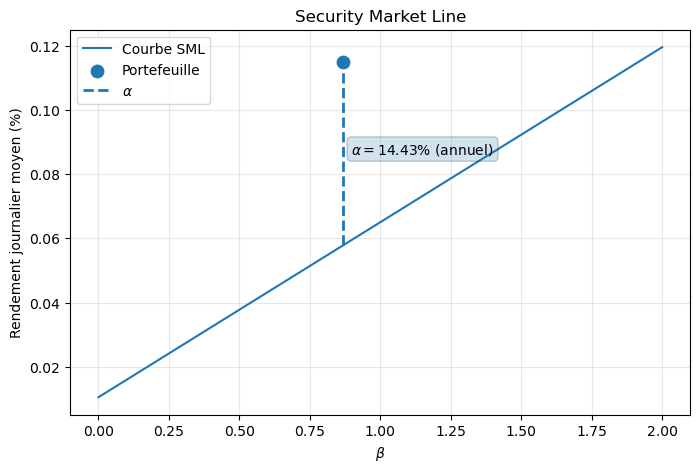

In [231]:
beta_range = np.linspace(0, 2, 100)
market_mean_daily = market_returns.mean().iloc[0]
sml_daily = Rf_mean_daily + beta_range * (market_mean_daily - Rf_mean_daily)
alpha_real = portfolio_returns.mean() - (Rf_mean_daily + beta_p * (market_mean_daily - Rf_mean_daily))

# Valeur CAPM attendue au beta du portefeuille
capm_expected = Rf_mean_daily + beta_p * (market_mean_daily - Rf_mean_daily)

plt.plot(beta_range, sml_daily*100, label="Courbe SML")
plt.scatter(beta_p, portfolio_returns.mean()*100, s=80, label="Portefeuille")

# Ligne verticale représentant l'alpha
plt.vlines(
    beta_p,
    capm_expected*100,
    portfolio_returns.mean()*100,
    linestyles="dashed",
    linewidth=2,
    label=r"$\alpha$"
)

plt.text(
    beta_p + 0.03,
    (capm_expected + portfolio_returns.mean())*50,
    rf"$\alpha = {round(alpha_real*252*100,2)}\%$ (annuel)",
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.xlabel(r"$\beta$")
plt.ylabel("Rendement journalier moyen (%)")
plt.title("Security Market Line")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Pour comprendre la signification des coefficients : 

• La droite CAPM : météo moyenne

• $\alpha$ : biais climatique (ville plus chaude que prévu)

• $\varepsilon$ : météo du jour (pluie, vent, nuages)

In [200]:
summary = pd.DataFrame({
    "Rendement annuel (%)": (mu * 100).round(2),
    "Volatilité annuelle (%)": (sigma * 100).round(2),
    "Beta CAPM": beta_series.round(3),
    "Alpha annuel (%)": (alpha_annual_series * 100).round(2),
    "R²": r2_series.round(3)
})

print("===== TABLEAU RÉCAPITULATIF DES ACTIFS =====")
print(summary.to_string())

===== TABLEAU RÉCAPITULATIF DES ACTIFS =====
           Rendement annuel (%)  Volatilité annuelle (%)  Beta CAPM  Alpha annuel (%)     R²
AMD                       50.47                    54.27      1.700             18.83  0.396
ASML                      43.79                    41.45      1.431             17.16  0.482
Hugo Boss                  5.90                    35.39      0.511             -3.61  0.084
Richemont                 22.15                    33.31      0.632             10.39  0.145


In [201]:
table_pro = summary.copy()
table_pro.columns = [
    r"Rendement annuel $(\%)$",
    r"Volatilité annuelle $(\%)$",
    r"$\beta$ (CAPM)",
    r"$\alpha_{annuel} (\%)$",
    r"$R^2$"
]

styled = (
    table_pro
    .style
    .format("{:.3f}")
    .background_gradient(cmap="Blues")
    #.set_caption("Tableau récapitulatif des actifs – Markowitz & CAPM")
)

display(styled)

,Rendement annuel $(\%)$,Volatilité annuelle $(\%)$,$\beta$ (CAPM),$\alpha_{annuel} (\%)$,$R^2$
AMD,50.470,54.270,1.700,18.830,0.396
ASML,43.790,41.450,1.431,17.160,0.482
Hugo Boss,5.900,35.390,0.511,-3.610,0.084
Richemont,22.150,33.310,0.632,10.390,0.145
